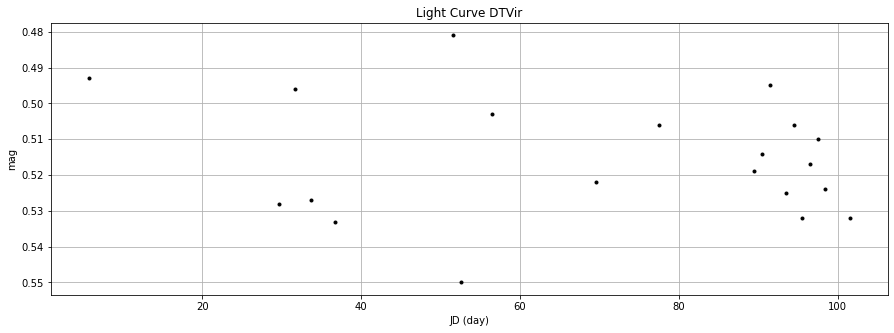

Input first day of the light curve plot (5.682000+)= 0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

###################### Inisiasi ###################
file = 'DTVir'
t = np.loadtxt(file+'.txt',usecols=0)
m = np.loadtxt(file+'.txt', usecols=1)


######################## Plot #####################

plt.figure(0,figsize=(15,5))
plt.plot(t, m, 'k.')
plt.xlabel('JD (day)')
plt.gca().invert_yaxis()
plt.ylabel('mag')
plt.title('Light Curve %s'%file)
plt.grid(True)
plt.show()

###################### Inisisasi 2 ###########################
t0 = t[0]
mulai = float(input('Input first day of the light curve plot (%f+)= '%t0))
selesai = float(input('Input last day of the light curve plot  (max = %f) = '%(t[len(t)-1])))
t2 = []
m2 = []
count = 0
N = len(t)
while mulai >= t[count]:
    count +=1
while selesai >= t[count]:
    t2.append(t[count])
    m2.append(m[count])
    count += 1
    if count == N:
        break
t = np.array(t2)
m = np.array(m2)

######################## Plot #####################

plt.figure(0,figsize=(15,5))
plt.plot(t, m, 'k.')
plt.xlabel('JD (%d+)'%t0)
plt.ylabel('mag')
plt.gca().invert_yaxis()
plt.title('Light curve %s'%file)
plt.grid(True)
plt.show()

####################### Perhitungan ##################

mr = np.mean(m)  # Mag rata-rata
f = m - mr       # simpangan dari rerata
Difdate = np.diff(t)  # Mencari selisih antar pengamatan
NP = 2*min(Difdate)  # Periode Nyquist, 2xselisih minimum

if NP == 0:
    fMax = float(input('Input maximum frequency (Nyquist frequency = undefined) = '))
else:
    fN = 1/NP  #1/Day  # Frekuensi Nyquist
    fMax = float(input('Input maximum frequency  (Nyquist frequency = %f) = ' %fN))


Nfreq = int(input('Input number of partition (number of data points) = '))
Df = fMax/Nfreq              #Selang frekuensi
fMin = float(input('Input the minimum frequency [resolution in requency] (>%f) = '%Df))
DT = date[N-1]-date[0]       #Lama observasi
Nfreq = int(fMax//Df)
#                ######## Perhitungan konstanta ##########

omega = np.linspace(fMin, fMax, Nfreq)    #bikin array omega

x = 2*np.pi*omega

a0 = np.sqrt(1/N)

S = np.zeros(Nfreq) 
C2 = []
C1 = []
A1 = []
A2 = []

for i in range(Nfreq):
    cos2x = np.sum(np.cos(x[i]*t)**2) 
    cosx2 = np.sum(np.cos(x[i]*t))**2
    sin2x = np.sum(np.sin(x[i]*t)**2) 
    sinx2 = np.sum(np.sin(x[i]*t))**2
    M = np.sum(np.cos(x[i]*t)*np.sin(x[i]*t)) - a0**2*np.sum(np.sin(x[i]*t))*np.sum(np.cos(x[i]*t))
    
    a1 = np.sqrt(1./(cos2x - a0**2*cosx2))
    a2 = np.sqrt(1./(sin2x - a0**2*sinx2 - a1**2*M**2))
    A1.append(a1)
    A2.append(a2)
    c1 = a1*np.sum(f*np.cos(x[i]*t))
    c2 = a2*np.sum(f*np.sin(x[i]*t)) - a1*a2*c1*M
    C2.append(c2)
    C1.append(c1)
    S[i] = (c1**2+c2**2)/np.sum(f**2)
    
G = -(N-3)/2*np.log(1-S)
H = (N-4)/(N-3)*(G+np.exp(-G)-1)
alpha = 2*(N-3)*DT*fMax/(3*(N-4))
C = 100*(1-np.exp(-H))**alpha
Period = 1/omega[np.argmax(H)]

############## Plot DCDFT ######################

fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot(omega, H, 'b-', label = 'H')
ax1.plot(omega, S, 'g-', label = 'S')
ax2 = ax1.twinx()
ax2.plot(omega, C, 'r-.', label = 'Conf Lvl')
fig.tight_layout()
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
ax1.set_xlabel('Frekuensi (1/D)')
ax1.set_ylabel('Power')
ax2.set_ylabel('Confidence Level (%)')
ax1.set_title('DCDFT Kurva cahaya %s'%file)
ax1.set_xlim(fMin,fMax)
plt.gca().invert_yaxis()
ax2.grid(color='k', linestyle='--', linewidth=.5, which='both', axis='y')
ax2.set_ylim(0,100)
ax1.set_ylim(0,max(H)*1.2)
plt.show()
########### Menentukan fase dan plot kurva cahayanya ##############

print('Period = %f days(s)'%Period)
print('Frequency = %f /day'%omega[np.argmax(H)])

print('Confidence Interval = %f%%' %max(C))
Ya = input('Use the period to plot the light curve? (y/n) = ')
if Ya == 'n':
    Period = float(input('Input the period = '))
fase = (t-t[0])/Period - (t-t[0])//Period
plt.figure(0,figsize=(15,5))
plt.plot(fase, m, 'k.')
plt.ylim(mr+min(f)*1.1,mr+max(f)*1.1)
plt.xlabel('Phase)')
plt.ylabel('mag')
plt.xlim(0,1)
plt.title('Light Curve %s'%file)
plt.grid(True)
plt.show()


In [51]:
##################### Pre proc ##################
N = len(date)      # Jumlah observasi
print('sebelum = ',N)
t = []
m = []
cek = np.full(N, True)
for i in range(N-1):
    if cek[i]:
        j = i+1
        count = 1
        Mag = mag[i]
        while date[i] == date[j]:
            Mag += mag[j]
            cek[j] =  False
            j += 1
            count += 1
            if j == N:
                break
        t.append(date[i])
        m.append(Mag/count)
t = np.array(t, dtype='float')
m = np.array(m, dtype='float')
N = len(t)
print('setelah = ',N)
#m = np.delete(m, np.argmax(m))
#t = np.delete(t, np.argmax(m))
t0 = t[0]

0.252272